In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from scipy.ndimage import gaussian_filter1d

import corner

import os

import requests

from hyperfit.linfit import LinFit

from desispec.io import read_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras

In [3]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# Data

## fuji

In [4]:
tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Separate the fuji data into center and off-center observations

In [5]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [6]:
first_digits = firstdigit(tfuji['TARGETID'])

fuji_centers = tfuji[first_digits == 3]
fuji_axis = tfuji[first_digits != 3]

/tmp/ipykernel_24216/917620242.py:16: RuntimeWarning: invalid value encountered in log10
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [7]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

#### Are there any galaxies with multiple good center observations?

In [8]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
  26199
  37543
  46327
  83216
  98934
 100987
 101569
 102832
    ...
1204188
1244275
1249892
1272144
1273084
1284002
1285273
1319490
1366241
1380792
1382772
Length = 87 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


## SGA

In [9]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [10]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [11]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.mean(good_centers['Z'][good_centers['SGA_ID'] == sga_id])
    SGA['ZERR_DESI'][SGA_idx] = np.mean(good_centers['ZERR'][good_centers['SGA_ID'] == sga_id]**2)/np.sum(good_centers['SGA_ID'] == sga_id)

# Coma cluster membership

Using Christoph's Coma cluster group catalog to identify cluster membership.

In [12]:
# Data table from Christoph
hdu = fits.open('../../../coma_filtered_inturnaround_desi.fits')
coma = Table(hdu[1].data)
hdu.close()

coma[:5]

target_id,sdss_id,ra,dec,z,z_err,spectype,survey,program,MASKBITS,BRICKNAME,BRICKID,BRICK_OBJID,PHOTSYS,HEALPIX,mag_app_g,mag_app_r,mag_app_z,mag_err_g,mag_err_r,mag_err_z,mag_abs_g,mag_abs_r,mag_abs_z,lum_g,lum_r,lum_z,in_desi,in_sdss,coma_fof,stillinsample,in_turnaround,delta_R,delta_v,vel
int64,int64,float32,float32,float32,float32,str6,str7,str6,int64,str8,int32,int64,str1,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,bool,float32,float32,float32
39628438616676024,0,194.95247,27.982782,0.017865099,7.050238e-05,GALAXY,sv3,bright,0,1948p280,486267,5816,S,10379,18.470928,17.85023,17.498695,0.0030093682,0.0031520368,0.0045542945,-16.56883,-17.184101,-17.52199,469388700.0,541552640.0,643866600.0,True,False,True,True,True,0.0038218938,-1623.1083,5307.9717
39628438616675858,1237667444048658525,194.94493,27.97384,0.03148476,1.1526019e-05,GALAXY,sv3,bright,4096,1948p280,486267,5650,S,10379,15.094151,14.261248,13.642706,0.00037747537,0.0003302651,0.00028316278,-19.98071,-20.784718,-21.386139,10871374000.0,14924069000.0,22618092000.0,True,True,True,True,True,0.016456442,2361.6345,9290.371
39628438616675869,1237667324334571832,194.94559,27.991917,0.027992504,4.7283545e-05,GALAXY,sv3,bright,0,1948p280,486267,5661,S,10379,18.121532,17.396067,16.905005,0.0024806096,0.0023175909,0.002864329,-16.943827,-17.647562,-18.120295,663027140.0,829897540.0,1117165800.0,True,True,True,True,True,0.022102475,1344.9799,8274.523
39628438616675853,0,194.94467,28.000118,0.020664731,5.7165307e-05,GALAXY,sv3,bright,0,1948p280,486267,5645,S,10379,18.573725,17.871141,17.43928,0.0038339326,0.0036676864,0.0050806683,-16.474808,-17.165623,-17.583746,430450800.0,532413120.0,681551940.0,True,False,True,True,True,0.035289522,-799.6845,6131.1187
39628438616676526,0,194.97472,27.970484,0.022671245,3.9218627e-05,GALAXY,sv3,bright,0,1948p280,486267,6318,S,10379,18.4861,17.734903,17.226023,0.0022412213,0.002148848,0.0026226363,-16.567638,-17.303455,-17.798859,468873600.0,604480900.0,830889500.0,True,False,True,True,True,0.036739178,-210.8955,6719.643


In [17]:
# Coma cluster statistics from Christoph
hdu = fits.open('../../../clusterstats.fits')
coma_stats = Table(hdu[1].data)
hdu.close()

coma_stats

dataset,ra_cluster,dec_cluster,z_cluster,N_cluster,N_in_turnaround,rho0_NFW,Rs_NFW,R200,R11,angular_halfradius,physical_halfradius,M_vir,M200,sigma_cluster
str4,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32
all,194.95291,27.980556,0.023343934,1721,1696,63058966000000.0,0.103641294,0.38078925,4.47818,1.355647,2.276394,2152028700000000.0,599057700000000.0,1602.1416
sdss,194.95291,27.980556,0.02333549,939,925,63864113000000.0,0.104248285,0.38644147,4.55943,1.4206662,2.3856175,2257739000000000.0,611125600000000.0,1579.727
desi,194.95291,27.980556,0.023390902,1529,1514,62939660000000.0,0.098865084,0.3627596,4.264075,1.2270335,2.0603573,2029884900000000.0,597276400000000.0,1638.7109


## Match up the PV survey center observations with the Coma cluster membership file

In [13]:
SGA_ID_in_Coma = []

for i in range(len(good_centers)):
    
    in_coma = coma['target_id'] == good_centers['TARGETID'][i]
    
    if np.sum(in_coma) > 0:
        # This galaxy is in the Coma cluster!
        SGA_ID_in_Coma.append(good_centers['SGA_ID'][i])

In [14]:
################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 249
fuji off-center observations in Coma: 844


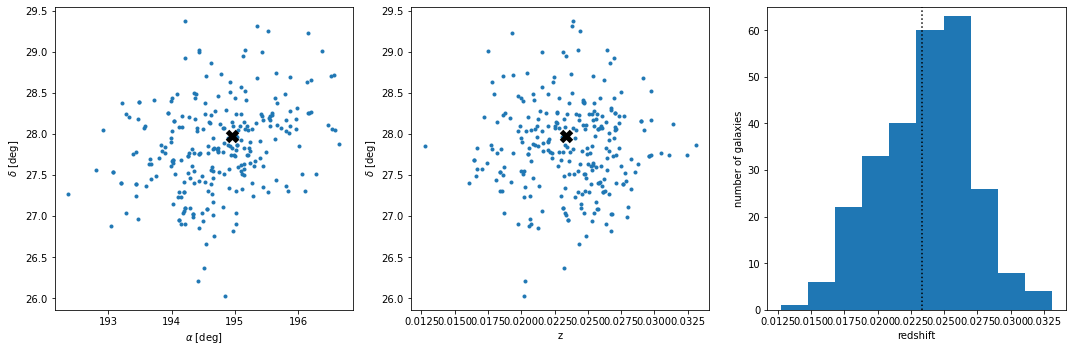

In [18]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(coma_stats['ra_cluster'][1], coma_stats['dec_cluster'][1], 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(coma_stats['z_cluster'][1], coma_stats['dec_cluster'][1], 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'])
plt.vlines(coma_stats['z_cluster'][1], 0, 65, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=65);

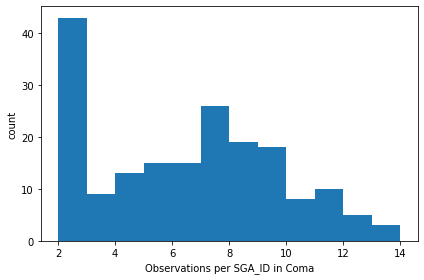

In [15]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# Calculate the rotational velocity

In [16]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

/tmp/ipykernel_41683/2270156695.py:56: RuntimeWarning: divide by zero encountered in true_divide
  axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))


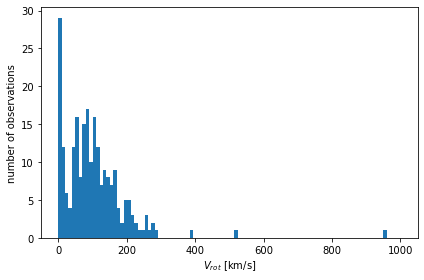

In [17]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for Coma galaxies suitable for calibrating the TFR

Requirements:
 * $V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [18]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = np.abs(axis_inComa['V_ROT']) < 1000

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

175 104


## Inclination angle cut

In [19]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_axis_inComa['iSGA'] = -1

for i in range(len(good_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_axis_inComa['SGA_ID'][i]]
    
    good_axis_inComa['iSGA'][i] = sga_idx
    
good_axis_inComa['cosi2'] = SGA['cosi2'][good_axis_inComa['iSGA']]

In [20]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

139 85


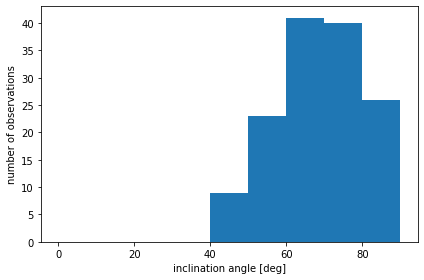

In [21]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_inComa['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

## Morphology cut

In [22]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [23]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
73 41


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [24]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [26]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    '''
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    ''';
    # break

cache/coma_39628443968603627.jpg exists.
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.04313321875534&dec=27.959071290945204&zoom=14&layer=ls-dr9&size=110&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=194.20691376173056&dec=27.093895925073287&zoom=14&layer=ls-dr9&size=328&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.84774376778842&dec=27.30687826270548&zoom=14&layer=ls-dr9&size=104&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=194.57594096774397&dec=27.848482700176607&zoom=14&layer=ls-dr9&size=159&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=193.63830652599466&dec=27.63275185427826&zoom=14&layer=ls-dr9&size=348&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.21296726515683&dec=27.742983900813208&zoom=14&layer=ls-dr9&size=177&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=193.06742023100352&dec=27.533158743696088&zoom=14&layer=ls-dr9&size=240&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?

In [28]:
VI_remove = Table.read('fuji_Coma_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

73 41


# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \bar{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [29]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [30]:
# Make a catalog of just those galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

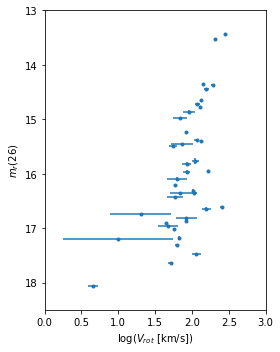

In [31]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.')

plt.xlim([0, 3])
plt.ylim([18.5, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

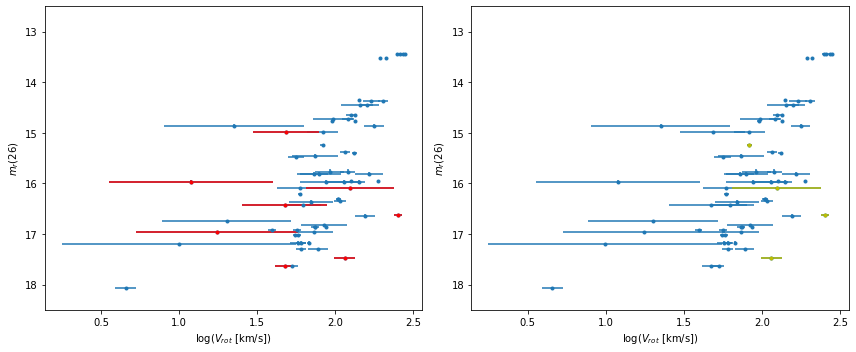

In [32]:
plt.figure(figsize=(12,5), tight_layout=True)


plt.subplot(121)

plt.errorbar(np.log10(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'])), 
             SGA['R_MAG_SB26'][VI_good_edge_spirals_axis_inComa['iSGA']], 
             xerr=0.434*VI_good_edge_spirals_axis_inComa['V_ROT_ERR']/VI_good_edge_spirals_axis_inComa['V_ROT'], 
             yerr = SGA['R_MAG_SB26_ERR'][VI_good_edge_spirals_axis_inComa['iSGA']], 
             fmt='.')

plt.errorbar(np.log10(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][VI_good_edge_spirals_axis_inComa['DELTACHI2'] < 25])), 
             SGA['R_MAG_SB26'][VI_good_edge_spirals_axis_inComa['iSGA'][VI_good_edge_spirals_axis_inComa['DELTACHI2'] < 25]], 
             xerr=0.434*VI_good_edge_spirals_axis_inComa['V_ROT_ERR'][VI_good_edge_spirals_axis_inComa['DELTACHI2'] < 25]/VI_good_edge_spirals_axis_inComa['V_ROT'][VI_good_edge_spirals_axis_inComa['DELTACHI2'] < 25], 
             yerr = SGA['R_MAG_SB26_ERR'][VI_good_edge_spirals_axis_inComa['iSGA'][VI_good_edge_spirals_axis_inComa['DELTACHI2'] < 25]], 
             fmt='r.')

plt.ylim([18.5, 12.5])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$')


plt.subplot(122)

plt.errorbar(np.log10(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'])), 
             SGA['R_MAG_SB26'][VI_good_edge_spirals_axis_inComa['iSGA']], 
             xerr=0.434*VI_good_edge_spirals_axis_inComa['V_ROT_ERR']/VI_good_edge_spirals_axis_inComa['V_ROT'], 
             yerr = SGA['R_MAG_SB26_ERR'][VI_good_edge_spirals_axis_inComa['iSGA']], 
             fmt='.')

plt.errorbar(np.log10(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][VI_good_edge_spirals_axis_inComa['ZWARN'] != 0])), 
             SGA['R_MAG_SB26'][VI_good_edge_spirals_axis_inComa['iSGA'][VI_good_edge_spirals_axis_inComa['ZWARN'] != 0]], 
             xerr=0.434*VI_good_edge_spirals_axis_inComa['V_ROT_ERR'][VI_good_edge_spirals_axis_inComa['ZWARN'] != 0]/VI_good_edge_spirals_axis_inComa['V_ROT'][VI_good_edge_spirals_axis_inComa['ZWARN'] != 0], 
             yerr = SGA['R_MAG_SB26_ERR'][VI_good_edge_spirals_axis_inComa['iSGA'][VI_good_edge_spirals_axis_inComa['ZWARN'] != 0]], 
             fmt='y.')

plt.ylim([18.5, 12.5])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Fit the TFR using `hyperfit`

### Create covariance matrix for `hyperfit`

In [33]:
Ndata = len(SGA_TF)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF['V_0p33R26_err'][i]/SGA_TF['V_0p33R26'][i])**2, 0.], [0., SGA_TF['R_MAG_SB26_ERR'][i]**2]])

### Create `hyperfit` object

In [34]:
hf = LinFit([np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']], cov)

### Run MCMC to fit TFR

In [35]:
bounds = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)

print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([-36.31603071])
     jac: array([-0.00153904,  0.00085691,  0.00044906])
 message: 'Optimization terminated successfully.'
    nfev: 4213
     nit: 92
 success: True
       x: array([4.56609374, 0.79124826, 0.21929113])


100%|██████████| 1000/1000 [00:00<00:00, 1020.64it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.94844015 49.09126532 44.44377826] / 2497.4220075483


100%|██████████| 1000/1000 [00:00<00:00, 1123.17it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.75184759 71.71699554 47.79376623] / 3585.849777038942


100%|██████████| 1000/1000 [00:00<00:00, 1032.68it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [73.62469552 71.21481847 50.7533086 ] / 3681.23477586876


100%|██████████| 1000/1000 [00:00<00:00, 1032.54it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [79.74237457 78.37173419 40.74819123] / 3987.118728594635


100%|██████████| 1000/1000 [00:00<00:00, 1080.25it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [90.95837601 88.78063244 40.71697306] / 4547.918800551333


100%|██████████| 1000/1000 [00:00<00:00, 1123.83it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [105.05600964 100.75976723  44.57691987] / 5252.800481834292


100%|██████████| 1000/1000 [00:00<00:00, 1131.49it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [115.44526    111.92691939  47.3501053 ] / 5772.262999895825


100%|██████████| 1000/1000 [00:00<00:00, 1125.07it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [97.39920869 96.17975766 49.92557894] / 4869.96043426352


100%|██████████| 1000/1000 [00:00<00:00, 1127.13it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.17388263 126.73935774  52.47136989] / 6608.694131566254


100%|██████████| 1000/1000 [00:00<00:00, 1128.88it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [141.95171972 137.70697805  55.26442179] / 7097.585986184325


100%|██████████| 1000/1000 [00:00<00:00, 1118.46it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.31157839 117.86286708  56.17338993] / 6065.578919542058


100%|██████████| 1000/1000 [00:00<00:00, 1119.96it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.26341721 124.73073993  55.87832257] / 6413.170860638283


100%|██████████| 1000/1000 [00:00<00:00, 1135.36it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [134.96640288 134.79625814  58.52291442] / 6748.320143953283


100%|██████████| 1000/1000 [00:00<00:00, 1103.21it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [138.10641564 134.75404714  55.99723756] / 6905.320781975909
[-5.88433667 27.35094659  1.4059111 ] [1.5514579  3.0283726  0.42633869]


### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [36]:
a, b, sig    = np.median(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -5.59 +/- 1.55
 26.78 +/- 3.03
  1.31 +/- 0.43


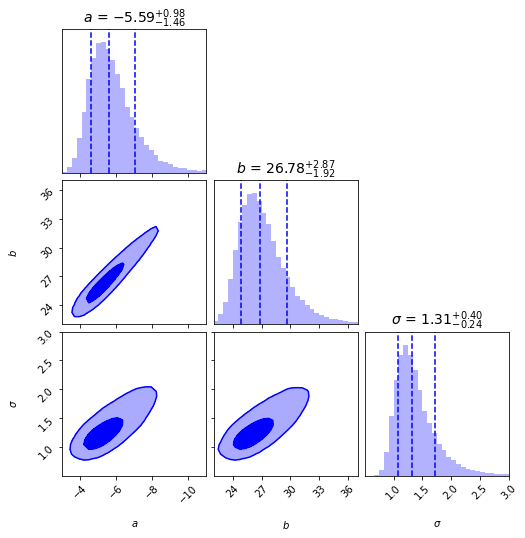

In [39]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
             range=[[-3, -11], [22, 37], [0.5, 3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

fig.savefig('../../Figures/SV/fuji_Coma_corner_20230124.png', dpi=150)

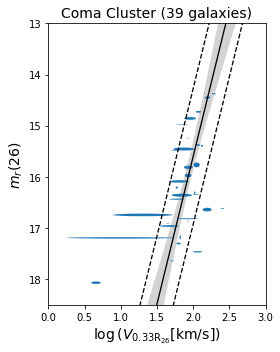

In [38]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']]
x_err = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']
y_err = SGA_TF['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
'''
fig = plt.figure(figsize=(3,5))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
'''
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    #e.set_color(cm.winter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    #e.set_alpha(0.9)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13)
'''
# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap=cm.winter),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)
''';

plt.savefig('../../Figures/SV/fuji_Coma_TFR_20230124.png', dpi=150)

In [42]:
SGA_TF['SGA_ID', 'PGC', 'RA', 'DEC', 'Z_DESI', 'V_0p33R26'].show_in_notebook()

idx,SGA_ID,PGC,RA,DEC,Z_DESI,V_0p33R26
0,25532,4107586,195.97667146704435,28.31062379047577,0.0267297616862906,44.65396060931472
1,98934,44212,194.20691376173056,27.093895925073287,0.0231520454727899,193.24217686760358
2,122260,4352806,195.84774376778842,27.30687826270548,0.0185712346342628,62.85335292303597
3,191275,1819621,194.57594096774397,27.848482700176607,0.025336855907803,20.176075305828697
4,196592,1813789,193.63830652599466,27.63275185427826,0.0243870264586433,157.36044493696974
5,202666,126751,195.21296726515683,27.742983900813208,0.0271247732365204,59.13058333024288
6,221178,43632,193.06742023100352,27.533158743696088,0.01842743057509275,83.41458816190627
7,291879,94015,195.4332574375834,28.999533006612396,0.0215321518628244,118.5012382060194
8,337817,1829562,194.1681558468321,28.21765798682762,0.0277290772613727,155.66791432189316
9,364410,1830228,193.281400534981,28.241241954832162,0.0234553864964975,56.40925323872185


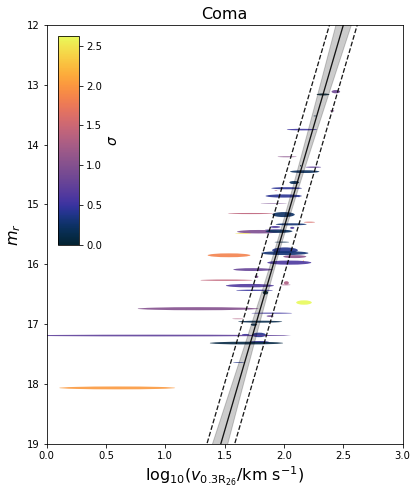